In [1]:
import os

from src.utils import utils

# Set up paths
data_folder = os.path.join("..", "data")
raw_data_path = os.path.join(data_folder, "external")
interim_data_path = os.path.join(data_folder, "interim")
proc_data_path = os.path.join(data_folder, "processed")

sampling_frequency = 100

# Load PTB-XL data
data, raw_labels = utils.load_dataset(
    raw_data_path, interim_data_path, sampling_frequency
)

# Preprocess label data
labels = utils.compute_label_aggregations(raw_labels, raw_data_path)

# Select relevant data and convert to one-hot
data, labels, Y, _ = utils.select_data(
    data, labels, min_samples=0, outputfolder=proc_data_path
)

# 1-9 for training 
X_train = data[labels.strat_fold < 10]
y_train = Y[labels.strat_fold < 10]
# 10 for validation
X_val = data[labels.strat_fold == 10]
y_val = Y[labels.strat_fold == 10]

num_classes = 5         # <=== number of classes in the finetuning dataset
input_shape = [1000,12] # <=== shape of samples, [None, 12] in case of different lengths

X_train.shape, y_train.shape, X_val.shape, y_val.shape

ModuleNotFoundError: No module named 'src'

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
from keras import models
import numpy as np
from keras import layers
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

In [17]:
#function to polt accuracy and loss graphics
def plot_acc_loss(his):
    pd.DataFrame(his.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show()
    
#function to plot multilabel confusion matrices
def multilabel_confusion_matrix(y_clf_pred, y_val, clf):
    f, axes = plt.subplots(1, 5, figsize=(25, 7))
    axes = axes.ravel()
    for i in range(5):
        disp = ConfusionMatrixDisplay(confusion_matrix(y_val[:, i],
                                                       y_clf_pred[:, i]),
                                                       display_labels=[0, 1])
        disp.plot(ax=axes[i], values_format='.4g', cmap='inferno')
        disp.ax_.set_title(clf  + f' class {i + 1}')
        
    
        if i!=0:
            disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    
    plt.show()
    
def threshold_round(sample, threshold):
    return 1 if sample > threshold else 0

vectorized_threshold_round = np.vectorize(threshold_round)

#function to get y_pred    
def y_pred(model_i, X_val, threshold):
    # make a prediction on the test set
    y_predicted = model_i.predict(X_val)
    # round probabilities to class labels
    y_predicted = vectorized_threshold_round(y_predicted, threshold)
    #y_predicted = y_predicted.round()
    return (y_predicted)

#function to get precision, recall and f1score
def get_metrics(y_val, y_pridicted, name):
    metrics = precision_recall_fscore_support(y_val, 
                                              y_pridicted, 
                                              average='samples', 
                                              zero_division = 0)
    
    print(name + '\nprecision: {0} \nrecall: {1} \nf1score: {2}'.format(*metrics))

Epoch 1/20
482/482 [==============================] - 3s 6ms/step - loss: 0.5603 - accuracy: 0.4293 - val_loss: 0.5452 - val_accuracy: 0.3993
Epoch 2/20
482/482 [==============================] - 2s 5ms/step - loss: 0.4488 - accuracy: 0.5325 - val_loss: 0.5444 - val_accuracy: 0.4219
Epoch 3/20
482/482 [==============================] - 3s 5ms/step - loss: 0.3469 - accuracy: 0.6331 - val_loss: 0.5932 - val_accuracy: 0.4058
Epoch 4/20
482/482 [==============================] - 2s 5ms/step - loss: 0.2613 - accuracy: 0.7210 - val_loss: 0.6862 - val_accuracy: 0.4162
Epoch 5/20
482/482 [==============================] - 3s 5ms/step - loss: 0.2062 - accuracy: 0.7784 - val_loss: 0.7987 - val_accuracy: 0.4248
Epoch 6/20
482/482 [==============================] - 2s 5ms/step - loss: 0.1693 - accuracy: 0.8165 - val_loss: 0.8194 - val_accuracy: 0.4133
Epoch 7/20
482/482 [==============================] - 2s 5ms/step - loss: 0.1340 - accuracy: 0.8379 - val_loss: 0.9533 - val_accuracy: 0.4037
Epoch 

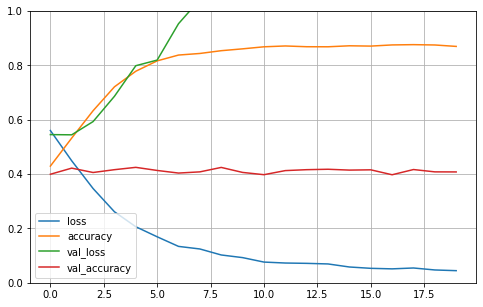

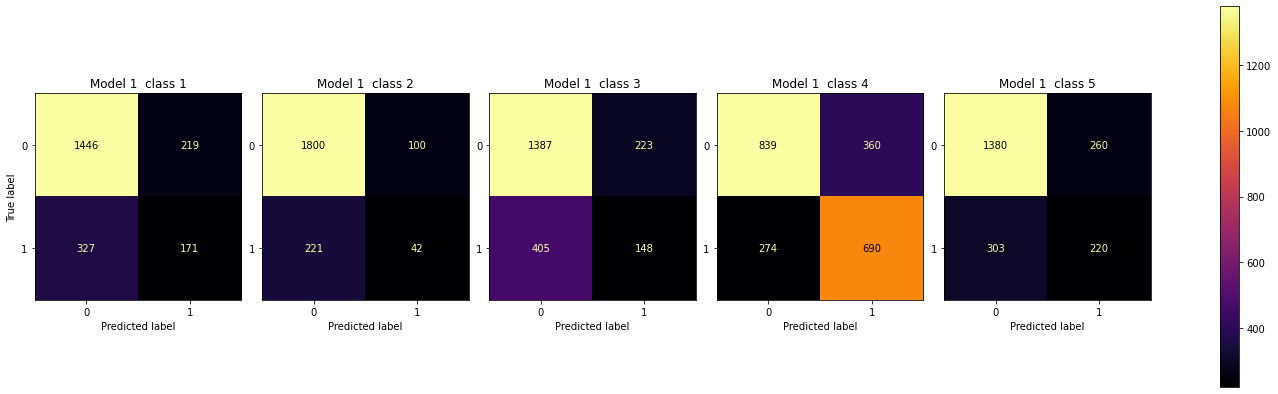

Model 1
precision: 0.4820080135614116 
recall: 0.4854368932038835 
f1score: 0.46856218215441514


In [19]:
model_1 = Sequential()

model_1.add(Flatten(input_shape=[1000, 12]))
model_1.add(Dense(300, activation='relu'))
model_1.add(Dense(100, activation='relu'))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(5, activation='sigmoid'))

model_1.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

history_1 = model_1.fit(X_train, y_train, epochs=20, validation_split=0.2)

score = model_1.evaluate(X_val, y_val)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

plot_acc_loss(history_1)
multilabel_confusion_matrix(y_pred(model_1, X_val), y_val, 'Model 1 ')
get_metrics(y_val, y_pred(model_1, X_val), "Model 1") 

Epoch 1/20
482/482 [==============================] - 11s 11ms/step - loss: 0.5639 - accuracy: 0.4402 - val_loss: 0.5623 - val_accuracy: 0.3656
Epoch 2/20
482/482 [==============================] - 5s 11ms/step - loss: 0.4939 - accuracy: 0.5140 - val_loss: 0.4734 - val_accuracy: 0.5322
Epoch 3/20
482/482 [==============================] - 5s 11ms/step - loss: 0.4313 - accuracy: 0.5874 - val_loss: 0.4478 - val_accuracy: 0.5516
Epoch 4/20
482/482 [==============================] - 5s 11ms/step - loss: 0.4123 - accuracy: 0.5904 - val_loss: 0.4374 - val_accuracy: 0.5418
Epoch 5/20
482/482 [==============================] - 5s 11ms/step - loss: 0.4025 - accuracy: 0.5985 - val_loss: 0.4323 - val_accuracy: 0.5558
Epoch 6/20
482/482 [==============================] - 5s 11ms/step - loss: 0.3957 - accuracy: 0.6029 - val_loss: 0.4260 - val_accuracy: 0.5664
Epoch 7/20
482/482 [==============================] - 5s 11ms/step - loss: 0.3871 - accuracy: 0.6065 - val_loss: 0.4095 - val_accuracy: 0.573

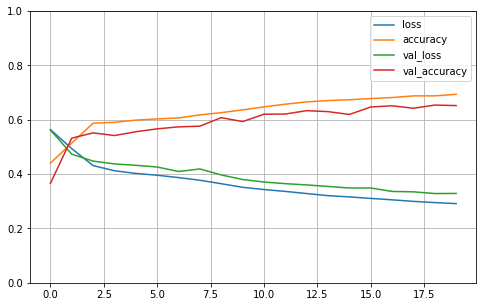

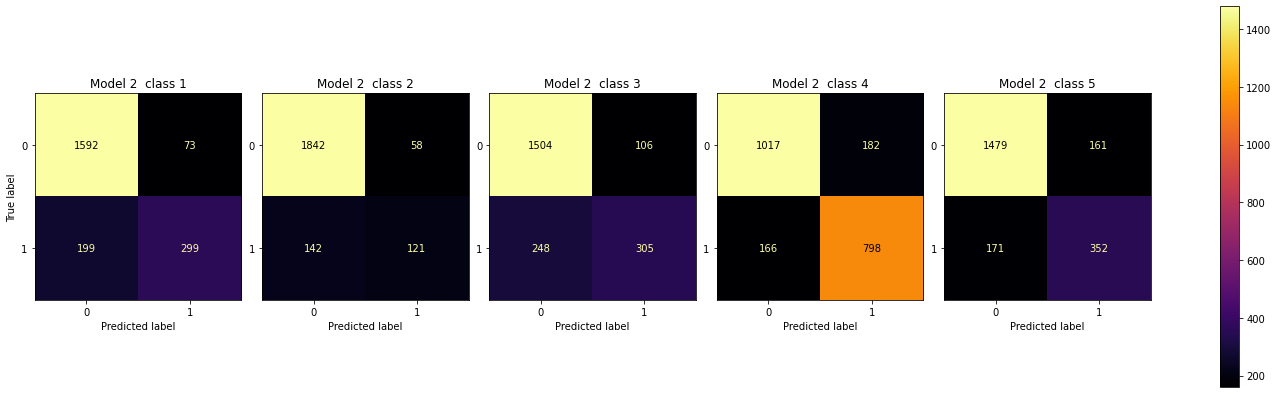

Model 2
precision: 0.7150562490368316 
recall: 0.6860070889197103 
f1score: 0.6859982828082689


In [20]:
model_2 = Sequential()

model_2.add(layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',input_shape=(1000,12)))
model_2.add(layers.MaxPooling1D(pool_size=100))
model_2.add(layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu',input_shape=(1000,12)))
model_2.add(layers.MaxPooling1D(pool_size=10))
model_2.add(layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu',input_shape=(1000,12)))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(300, 'sigmoid', kernel_initializer="he_normal"))
model_2.add(layers.Dense(100, 'sigmoid', kernel_initializer="he_normal"))
model_2.add(layers.Dense(50, 'sigmoid', kernel_initializer="he_normal"))
model_2.add(layers.Dense(10, 'sigmoid', kernel_initializer="he_normal"))
model_2.add(layers.Dense(5, activation='sigmoid'))

model_2.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

history_2 = model_2.fit(X_train, y_train, epochs=20, validation_split=0.2)

score = model_2.evaluate(X_val, y_val)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

plot_acc_loss(history_2)
multilabel_confusion_matrix(y_pred(model_2, X_val), y_val, 'Model 2 ')
get_metrics(y_val, y_pred(model_2, X_val), "Model 2") 

Epoch 1/20
482/482 [==============================] - 14s 25ms/step - loss: 0.4717 - accuracy: 0.5850 - val_loss: 0.4166 - val_accuracy: 0.5182
Epoch 2/20
482/482 [==============================] - 12s 25ms/step - loss: 0.3644 - accuracy: 0.6341 - val_loss: 0.3820 - val_accuracy: 0.5509
Epoch 3/20
482/482 [==============================] - 12s 25ms/step - loss: 0.3452 - accuracy: 0.6437 - val_loss: 0.3665 - val_accuracy: 0.6341
Epoch 4/20
482/482 [==============================] - 12s 24ms/step - loss: 0.3332 - accuracy: 0.6524 - val_loss: 0.3544 - val_accuracy: 0.6079
Epoch 5/20
482/482 [==============================] - 12s 24ms/step - loss: 0.3285 - accuracy: 0.6589 - val_loss: 0.3563 - val_accuracy: 0.5908
Epoch 6/20
482/482 [==============================] - 12s 25ms/step - loss: 0.3228 - accuracy: 0.6680 - val_loss: 0.3552 - val_accuracy: 0.6059
Epoch 7/20
482/482 [==============================] - 12s 24ms/step - loss: 0.3187 - accuracy: 0.6708 - val_loss: 0.3527 - val_accuracy:

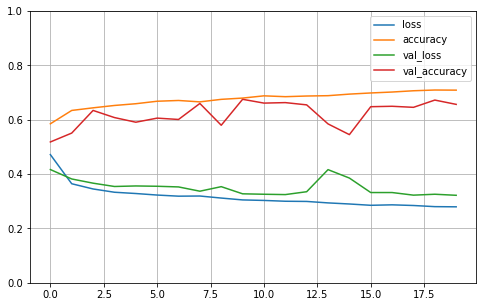

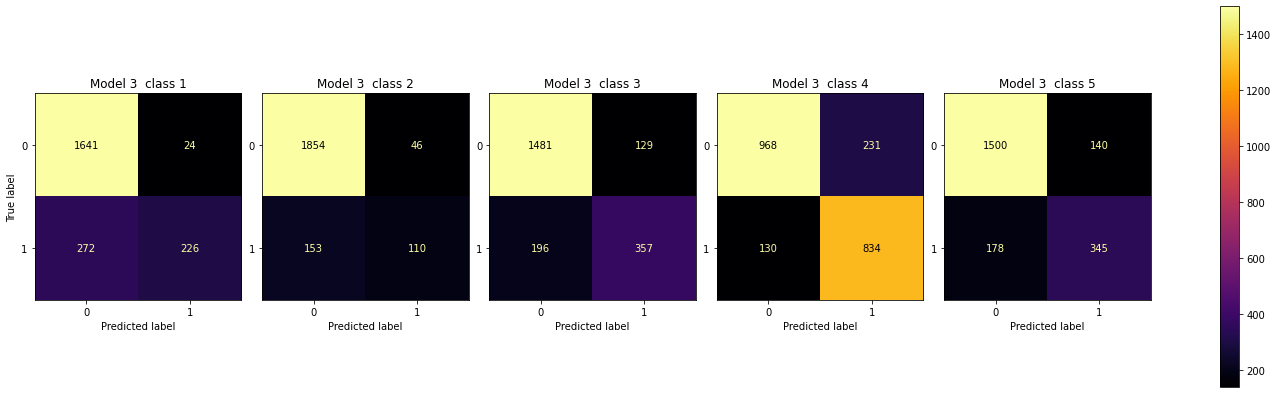

Model 3
precision: 0.7376714439821237 
recall: 0.6974495299738018 
f1score: 0.7030315038636814


In [21]:
model_3 = Sequential()

model_3.add(layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',input_shape=(1000,12)))
model_3.add(layers.BatchNormalization())
model_3.add(layers.MaxPooling1D(pool_size=100))
model_3.add(layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu',input_shape=(1000,12)))
model_3.add(layers.BatchNormalization())
model_3.add(layers.MaxPooling1D(pool_size=10))
model_3.add(layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu',input_shape=(1000,12)))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Flatten())
model_3.add(layers.BatchNormalization())
model_3.add(layers.Dense(300, 'sigmoid', kernel_initializer="he_normal"))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Dense(100, 'sigmoid', kernel_initializer="he_normal"))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Dense(50, 'sigmoid', kernel_initializer="he_normal"))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Dense(10, 'sigmoid', kernel_initializer="he_normal"))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Dense(5, activation='sigmoid'))

model_3.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

history_3 = model_3.fit(X_train, y_train, epochs=20, validation_split=0.2)

score = model_3.evaluate(X_val, y_val)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

plot_acc_loss(history_3)
multilabel_confusion_matrix(y_pred(model_3, X_val), y_val, 'Model 3 ')
get_metrics(y_val, y_pred(model_3, X_val), "Model 3") 

Epoch 1/20
482/482 [==============================] - 13s 24ms/step - loss: 0.4615 - accuracy: 0.5924 - val_loss: 0.4129 - val_accuracy: 0.5615
Epoch 2/20
482/482 [==============================] - 11s 23ms/step - loss: 0.3528 - accuracy: 0.6404 - val_loss: 0.4152 - val_accuracy: 0.6040
Epoch 3/20
482/482 [==============================] - 11s 23ms/step - loss: 0.3409 - accuracy: 0.6543 - val_loss: 0.3401 - val_accuracy: 0.6367
Epoch 4/20
482/482 [==============================] - 11s 23ms/step - loss: 0.3284 - accuracy: 0.6587 - val_loss: 0.3919 - val_accuracy: 0.6199
Epoch 5/20
482/482 [==============================] - 11s 23ms/step - loss: 0.3263 - accuracy: 0.6629 - val_loss: 0.3486 - val_accuracy: 0.6129
Epoch 6/20
482/482 [==============================] - 11s 23ms/step - loss: 0.3193 - accuracy: 0.6714 - val_loss: 0.3271 - val_accuracy: 0.6386
Epoch 7/20
482/482 [==============================] - 11s 23ms/step - loss: 0.3113 - accuracy: 0.6800 - val_loss: 0.3595 - val_accuracy:

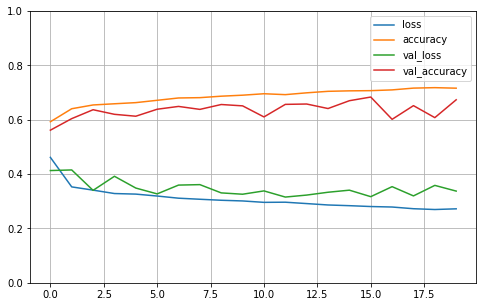

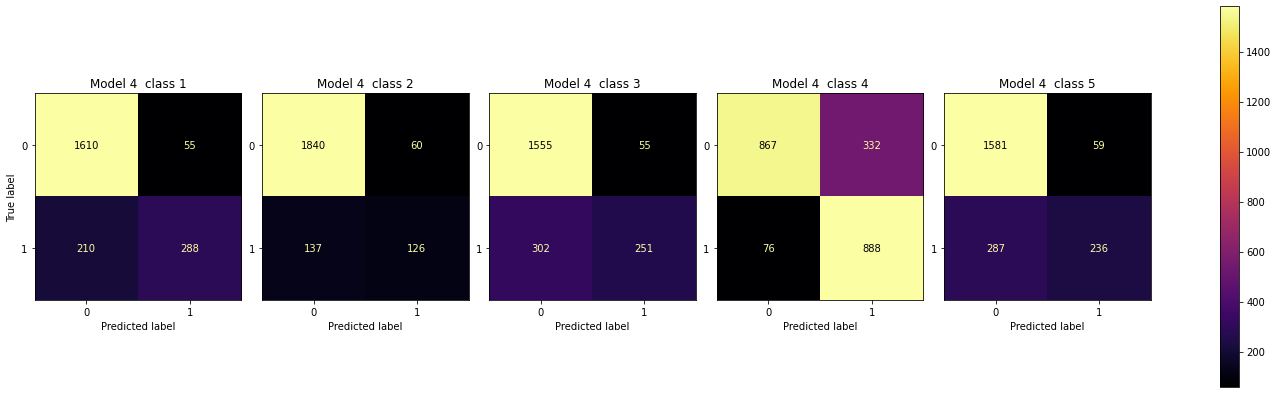

Model 4
precision: 0.7189859762675297 
recall: 0.6712128216982586 
f1score: 0.6811285031812078


In [22]:
model_4 = Sequential()

model_4.add(layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',input_shape=(1000,12)))
model_4.add(layers.BatchNormalization())
model_4.add(layers.MaxPooling1D(pool_size=100))
model_4.add(layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model_4.add(layers.BatchNormalization())
model_4.add(layers.MaxPooling1D(pool_size=10))
model_4.add(layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Flatten())
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dense(50, 'sigmoid', kernel_initializer="he_normal"))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dense(100, 'sigmoid', kernel_initializer="he_normal"))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dense(25, 'sigmoid', kernel_initializer="he_normal"))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dense(5, activation='sigmoid'))


model_4.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

history_4 = model_4.fit(X_train, y_train, epochs=20, validation_split=0.2)

score = model_4.evaluate(X_val, y_val)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

plot_acc_loss(history_4)
multilabel_confusion_matrix(y_pred(model_4, X_val), y_val, 'Model 4 ')
get_metrics(y_val, y_pred(model_4, X_val), "Model 4") 

Epoch 1/20
482/482 [==============================] - 13s 25ms/step - loss: 0.5667 - accuracy: 0.4689 - val_loss: 0.4771 - val_accuracy: 0.4870
Epoch 2/20
482/482 [==============================] - 12s 24ms/step - loss: 0.4298 - accuracy: 0.5626 - val_loss: 0.4237 - val_accuracy: 0.5672
Epoch 3/20
482/482 [==============================] - 12s 24ms/step - loss: 0.4090 - accuracy: 0.5837 - val_loss: 0.4107 - val_accuracy: 0.5890
Epoch 4/20
482/482 [==============================] - 12s 25ms/step - loss: 0.3981 - accuracy: 0.5925 - val_loss: 0.4053 - val_accuracy: 0.6022
Epoch 5/20
482/482 [==============================] - 12s 24ms/step - loss: 0.3883 - accuracy: 0.6079 - val_loss: 0.3981 - val_accuracy: 0.6108
Epoch 6/20
482/482 [==============================] - 12s 24ms/step - loss: 0.3823 - accuracy: 0.6117 - val_loss: 0.3747 - val_accuracy: 0.6124
Epoch 7/20
482/482 [==============================] - 12s 24ms/step - loss: 0.3784 - accuracy: 0.6184 - val_loss: 0.3856 - val_accuracy:

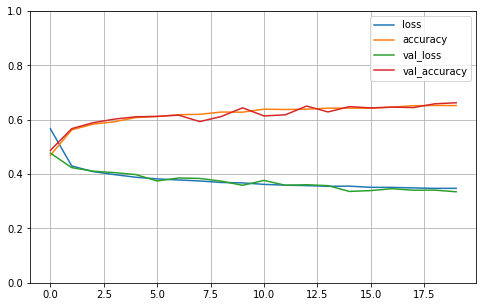

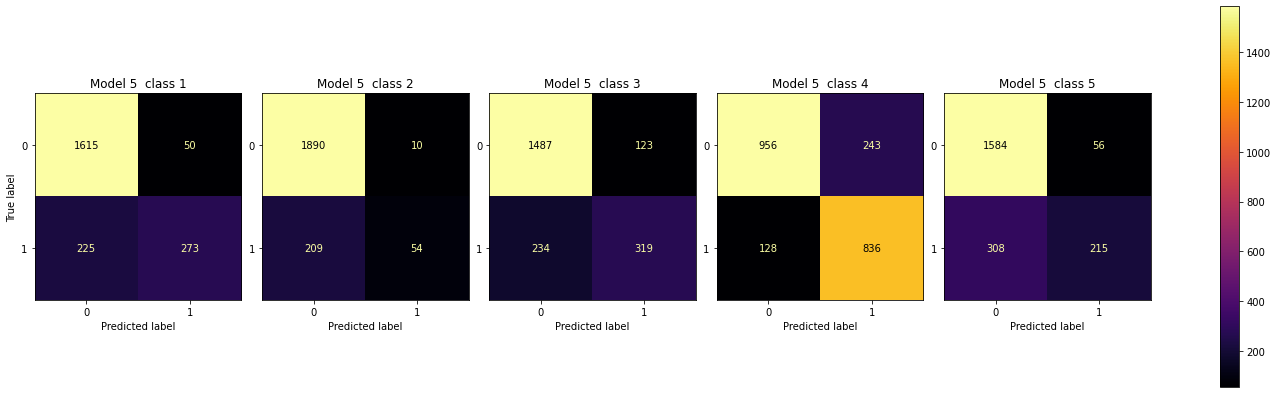

Model 5
precision: 0.6879334257975035 
recall: 0.6401602712282324 
f1score: 0.6517777337472205


In [25]:
model_5 = Sequential()

model_5.add(layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',input_shape=(1000,12)))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPooling1D(pool_size=100))
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPooling1D(pool_size=10))
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Flatten())
model_5.add(layers.BatchNormalization())
model_5.add(layers.Dense(50, 'sigmoid', kernel_initializer="he_normal"))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Dense(100, 'sigmoid', kernel_initializer="he_normal"))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Dense(25, 'sigmoid', kernel_initializer="he_normal"))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Dense(5, activation='sigmoid'))


model_5.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

history_5 = model_5.fit(X_train, y_train, epochs=20, validation_split=0.2)

score = model_5.evaluate(X_val, y_val)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

plot_acc_loss(history_5)
multilabel_confusion_matrix(y_pred(model_5, X_val), y_val, 'Model 5 ')
get_metrics(y_val, y_pred(model_5, X_val), "Model 5") 

Epoch 1/20
482/482 [==============================] - 14s 26ms/step - loss: 0.5764 - accuracy: 0.4635 - val_loss: 0.4858 - val_accuracy: 0.4167
Epoch 2/20
482/482 [==============================] - 12s 25ms/step - loss: 0.4452 - accuracy: 0.5578 - val_loss: 0.4327 - val_accuracy: 0.5771
Epoch 3/20
482/482 [==============================] - 12s 25ms/step - loss: 0.4214 - accuracy: 0.5707 - val_loss: 0.4063 - val_accuracy: 0.5848
Epoch 4/20
482/482 [==============================] - 12s 25ms/step - loss: 0.4098 - accuracy: 0.5848 - val_loss: 0.4238 - val_accuracy: 0.5698
Epoch 5/20
482/482 [==============================] - 12s 25ms/step - loss: 0.4040 - accuracy: 0.5878 - val_loss: 0.3875 - val_accuracy: 0.6051
Epoch 6/20
482/482 [==============================] - 12s 25ms/step - loss: 0.3994 - accuracy: 0.5924 - val_loss: 0.3876 - val_accuracy: 0.6105
Epoch 7/20
482/482 [==============================] - 12s 24ms/step - loss: 0.3965 - accuracy: 0.5966 - val_loss: 0.4002 - val_accuracy:

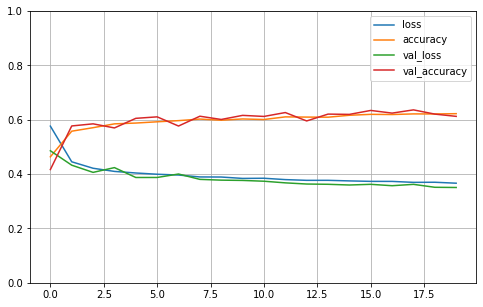

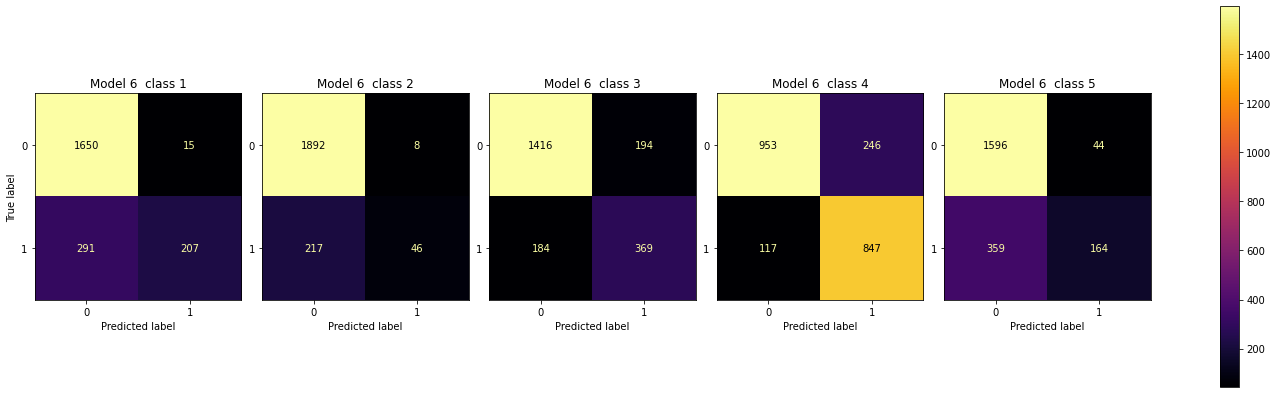

Model 6
precision: 0.6652797041146555 
recall: 0.6191246725227307 
f1score: 0.6282698192545626


In [24]:
model_6 = Sequential()

model_6.add(layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',input_shape=(1000,12)))
model_6.add(layers.BatchNormalization())
model_6.add(layers.MaxPooling1D(pool_size=100))
model_6.add(layers.Dropout(0.5))
model_6.add(layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model_6.add(layers.BatchNormalization())
model_6.add(layers.MaxPooling1D(pool_size=10))
model_6.add(layers.Dropout(0.5))
model_6.add(layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model_6.add(layers.BatchNormalization())
model_6.add(layers.Flatten())
model_6.add(layers.Dense(300, 'sigmoid', kernel_initializer="he_normal"))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.BatchNormalization())
model_6.add(layers.Dense(100, 'sigmoid', kernel_initializer="he_normal"))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.BatchNormalization())
model_6.add(layers.Dense(50, 'sigmoid', kernel_initializer="he_normal"))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.BatchNormalization())
model_6.add(layers.Dense(10, 'sigmoid', kernel_initializer="he_normal"))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.BatchNormalization())
model_6.add(layers.Dense(5, activation='sigmoid'))

model_6.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

history_6 = model_6.fit(X_train, y_train, epochs=20, validation_split=0.2)

score = model_6.evaluate(X_val, y_val)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

plot_acc_loss(history_6)
multilabel_confusion_matrix(y_pred(model_6, X_val), y_val, 'Model 6 ')
get_metrics(y_val, y_pred(model_6, X_val), "Model 6") 

Epoch 1/20
482/482 [==============================] - 11s 20ms/step - loss: 0.5331 - accuracy: 0.4783 - val_loss: 0.4909 - val_accuracy: 0.4629
Epoch 2/20
482/482 [==============================] - 10s 20ms/step - loss: 0.4464 - accuracy: 0.5460 - val_loss: 0.4417 - val_accuracy: 0.5755
Epoch 3/20
482/482 [==============================] - 10s 20ms/step - loss: 0.4236 - accuracy: 0.5684 - val_loss: 0.4244 - val_accuracy: 0.5991
Epoch 4/20
482/482 [==============================] - 10s 20ms/step - loss: 0.4057 - accuracy: 0.5872 - val_loss: 0.4133 - val_accuracy: 0.6009
Epoch 5/20
482/482 [==============================] - 10s 20ms/step - loss: 0.3956 - accuracy: 0.5990 - val_loss: 0.4019 - val_accuracy: 0.5877
Epoch 6/20
482/482 [==============================] - 10s 20ms/step - loss: 0.3905 - accuracy: 0.6021 - val_loss: 0.3875 - val_accuracy: 0.6103
Epoch 7/20
482/482 [==============================] - 10s 21ms/step - loss: 0.3841 - accuracy: 0.6107 - val_loss: 0.3883 - val_accuracy:

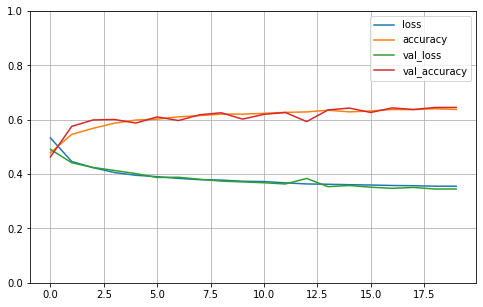

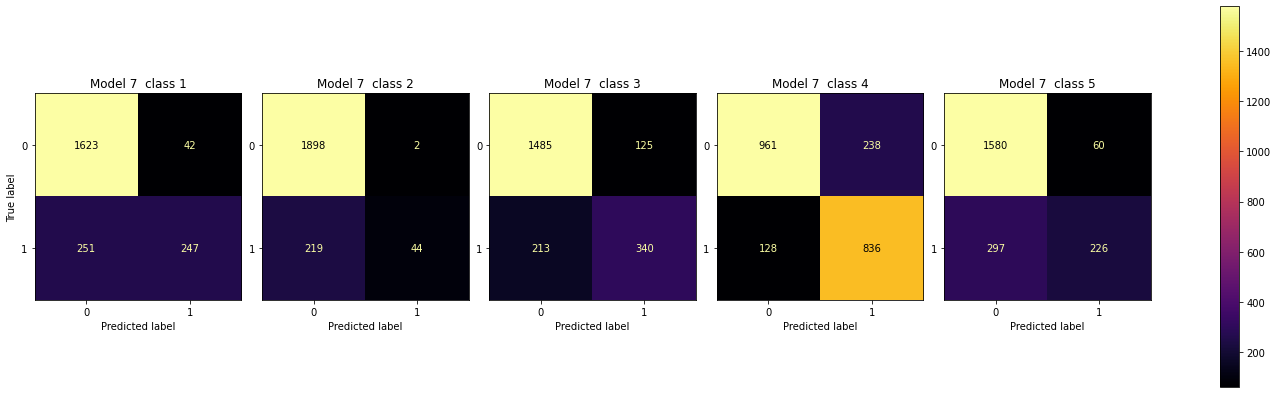

Model 7
precision: 0.6944829711820002 
recall: 0.6415472337802434 
f1score: 0.655269356933712


In [29]:
model_7 = Sequential()

model_7.add(layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',input_shape=(1000,12)))
model_7.add(layers.BatchNormalization())
model_7.add(layers.MaxPooling1D(pool_size=100))
model_7.add(layers.Dropout(0.5))
model_7.add(layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.MaxPooling1D(pool_size=10))
model_7.add(layers.Dropout(0.5))
model_7.add(layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.Flatten())
model_7.add(layers.Dense(300, 'sigmoid'))
model_7.add(layers.Dropout(0.2))
model_7.add(layers.Dense(100, 'sigmoid', kernel_initializer="he_normal"))
model_7.add(layers.BatchNormalization())
model_7.add(layers.Dense(50, 'sigmoid'))
model_7.add(layers.Dense(10, 'sigmoid'))
model_7.add(layers.Dropout(0.2))
model_7.add(layers.Dense(5, activation='sigmoid'))

model_7.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

history_7 = model_7.fit(X_train, y_train, epochs=20, validation_split=0.2)

score = model_7.evaluate(X_val, y_val)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

plot_acc_loss(history_7)
multilabel_confusion_matrix(y_pred(model_7, X_val), y_val, 'Model 7 ')
get_metrics(y_val, y_pred(model_7, X_val), "Model 7") 

Epoch 1/20
482/482 [==============================] - 10s 17ms/step - loss: 0.4290 - accuracy: 0.5512 - val_loss: 0.3720 - val_accuracy: 0.6108
Epoch 2/20
482/482 [==============================] - 8s 17ms/step - loss: 0.3368 - accuracy: 0.6544 - val_loss: 0.3277 - val_accuracy: 0.6640
Epoch 3/20
482/482 [==============================] - 8s 17ms/step - loss: 0.3141 - accuracy: 0.6741 - val_loss: 0.3051 - val_accuracy: 0.6796
Epoch 4/20
482/482 [==============================] - 8s 17ms/step - loss: 0.2971 - accuracy: 0.6909 - val_loss: 0.2977 - val_accuracy: 0.6785
Epoch 5/20
482/482 [==============================] - 8s 17ms/step - loss: 0.2895 - accuracy: 0.7010 - val_loss: 0.3047 - val_accuracy: 0.6383
Epoch 6/20
482/482 [==============================] - 8s 17ms/step - loss: 0.2834 - accuracy: 0.6985 - val_loss: 0.2831 - val_accuracy: 0.6910
Epoch 7/20
482/482 [==============================] - 8s 17ms/step - loss: 0.2769 - accuracy: 0.7078 - val_loss: 0.2840 - val_accuracy: 0.689

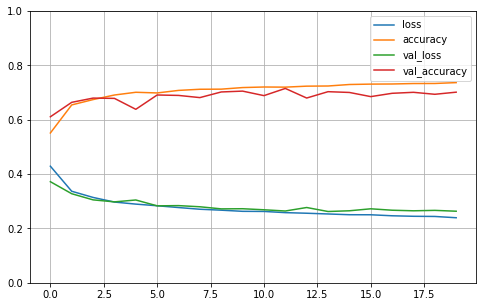

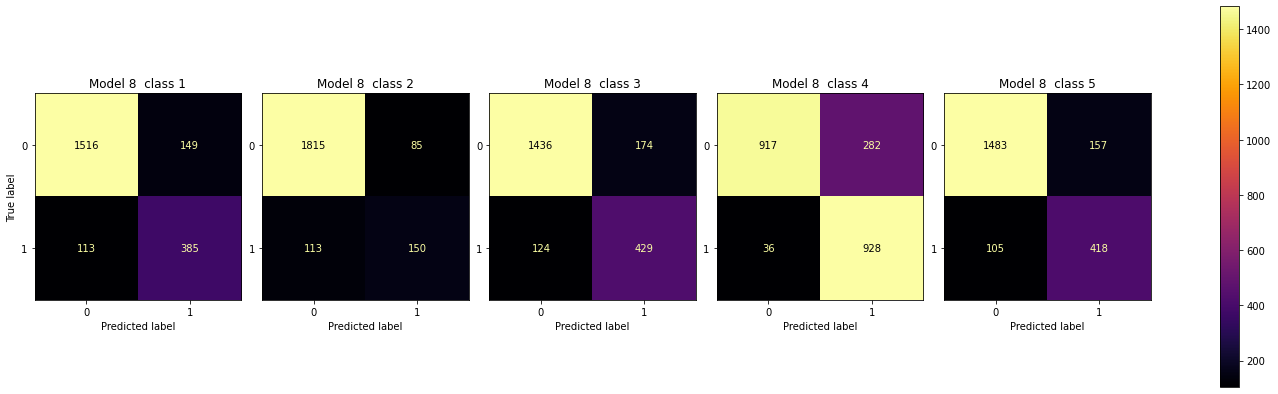

Model 8
precision: 0.7773154569271075 
recall: 0.8436199722607489 
f1score: 0.7883385069238051


In [21]:
model_8 = Sequential()

model_8.add(layers.Convolution1D(filters=16, kernel_size=5, activation='relu', padding="valid"))
model_8.add(layers.Convolution1D(filters=16, kernel_size=5, activation='relu', padding="valid"))
model_8.add(layers.MaxPool1D(pool_size=2))
model_8.add(layers.Dropout(0.1))
model_8.add(layers.Convolution1D(filters=32, kernel_size=3, activation='relu', padding="valid"))
model_8.add(layers.Convolution1D(filters=32, kernel_size=3, activation='relu', padding="valid"))
model_8.add(layers.MaxPool1D(pool_size=2))
model_8.add(layers.Dropout(0.1))
model_8.add(layers.Convolution1D(filters=32, kernel_size=3, activation='relu', padding="valid"))
model_8.add(layers.Convolution1D(filters=32, kernel_size=3, activation='relu', padding="valid"))
model_8.add(layers.MaxPool1D(pool_size=2))
model_8.add(layers.Dropout(0.1))
model_8.add(layers.Convolution1D(filters=256, kernel_size=3, activation='relu', padding="valid"))
model_8.add(layers.Convolution1D(filters=256, kernel_size=3, activation='relu', padding="valid"))
model_8.add(layers.GlobalMaxPool1D())
model_8.add(layers.Dropout(0.2))

model_8.add(layers.Dense(64, activation='relu'))
model_8.add(layers.Dense(64, activation='relu'))
model_8.add(layers.Dense(5, activation='sigmoid'))

model_8.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

history_8 = model_8.fit(X_train, y_train, epochs=20, validation_split=0.2)

score = model_8.evaluate(X_val, y_val)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

thresholds = [0.30, 0.25, 0.32, 0.35, 0.34]
plot_acc_loss(history_8)
multilabel_confusion_matrix(y_pred(model_8, X_val, thresholds), y_val, 'Model 8 ')
get_metrics(y_val, y_pred(model_8, X_val, thresholds), "Model 8") 